# Распознавание "морд" при помощи SVM и kernel trick

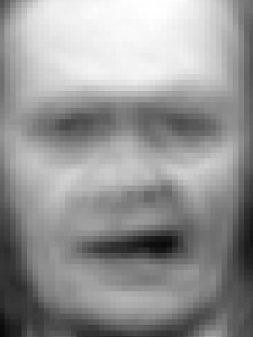

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

plt.style.use('ggplot')

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет.

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [51]:
df = pd.read_csv('persons_pics_train.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.379085,0.312418,0.352941,0.445752,0.466667,0.473203,0.484967,0.513725,0.545098,0.571242,...,0.597386,0.620915,0.732026,0.852288,0.921569,0.937255,0.941176,0.950327,0.946405,John Ashcroft
1,0.450980,0.466667,0.512418,0.509804,0.450980,0.458824,0.516340,0.571242,0.607843,0.618301,...,0.430065,0.453595,0.679739,0.934640,0.985621,0.981699,0.963399,0.938562,0.874510,Ariel Sharon
2,0.589542,0.614379,0.688889,0.729412,0.738562,0.775163,0.789543,0.806536,0.820915,0.837908,...,0.733333,0.854902,0.937255,0.624837,0.128105,0.082353,0.107190,0.095425,0.100654,Colin Powell
3,0.390850,0.432680,0.499346,0.562091,0.597386,0.644444,0.670588,0.650980,0.637908,0.639216,...,0.713726,0.898039,0.968627,0.959477,0.832680,0.443137,0.266667,0.303268,0.313725,Jean Chretien
4,0.645752,0.626144,0.605229,0.585621,0.602614,0.664052,0.701961,0.709804,0.733333,0.771242,...,0.115033,0.129412,0.132026,0.129412,0.155556,0.171242,0.167320,0.176471,0.183007,Colin Powell


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения:

In [52]:
def get_img_by_row(row):
    return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

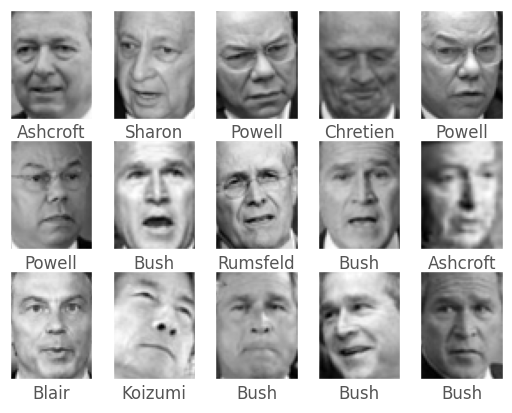

In [53]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
# plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')

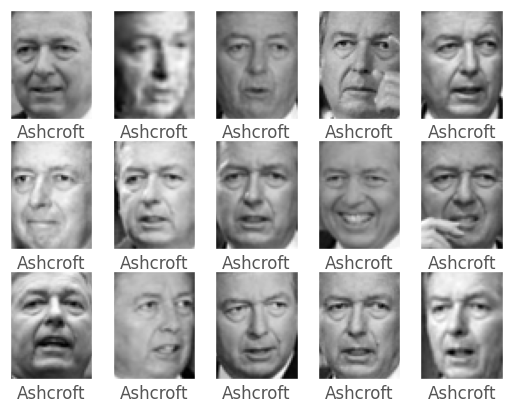

In [54]:
subset = df[df.label == 'John Ashcroft'].reset_index(drop=True)
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(subset.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[], xlabel=lbl.split()[-1])

Крупнее

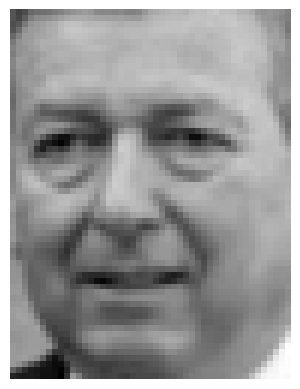

In [55]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')
plt.show()

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных:

In [56]:
df.label.nunique()

12

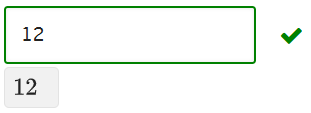

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса:

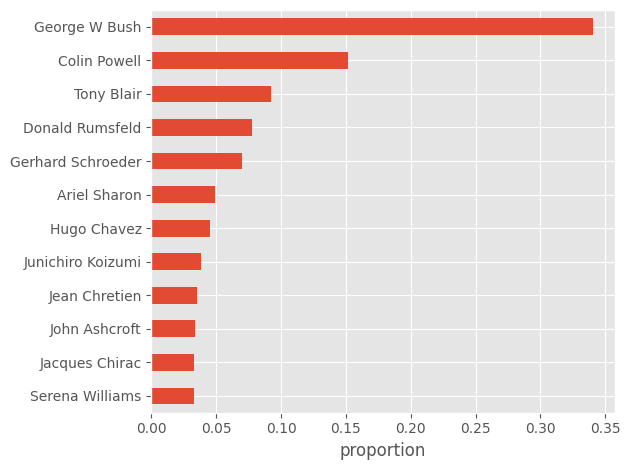

In [57]:
counts = df.label.value_counts(normalize=True).sort_values()
counts.plot(kind='barh')
plt.xlabel('proportion')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [58]:
counts.round(3)

,proportion
label,
Serena Williams,0.033
Jacques Chirac,0.033
John Ashcroft,0.034
Jean Chretien,0.035
Junichiro Koizumi,0.038
Hugo Chavez,0.045
Ariel Sharon,0.049
Gerhard Schroeder,0.070
Donald Rumsfeld,0.078


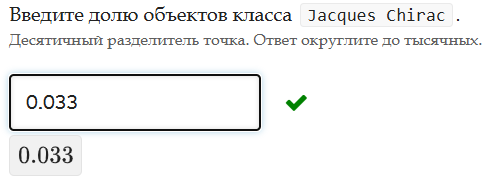

На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком:

In [59]:
mean_faces = df.groupby('label').mean()
mean_faces

,0,1,2,3,4,5,6,7,8,9,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
label,,,,,,,,,,,,,,,,,,,,,
Ariel Sharon,0.501398,0.514811,0.532609,0.551714,0.569754,0.577456,0.581820,0.591835,0.604465,0.612589,...,0.396400,0.433947,0.478291,0.519920,0.532549,0.515656,0.498220,0.486657,0.466928,0.437687
Colin Powell,0.433512,0.441147,0.456248,0.471947,0.486730,0.513732,0.545157,0.566514,0.581556,0.592924,...,0.437869,0.471798,0.512067,0.534615,0.532176,0.510006,0.477586,0.448119,0.410659,0.379605
Donald Rumsfeld,0.404810,0.417260,0.442731,0.474028,0.507938,0.541659,0.560112,0.571838,0.585773,0.602386,...,0.494917,0.546837,0.562307,0.558627,0.549426,0.525947,0.500603,0.475550,0.431893,0.391738
George W Bush,0.348179,0.360263,0.381659,0.416669,0.457154,0.488335,0.515398,0.536075,0.551153,0.565662,...,0.385818,0.414092,0.441074,0.461325,0.470275,0.459067,0.447653,0.430523,0.399620,0.376584
Gerhard Schroeder,0.210162,0.228210,0.268255,0.328344,0.389332,0.447115,0.495003,0.527655,0.549441,0.569457,...,0.414969,0.430937,0.469281,0.494596,0.496718,0.482550,0.442252,0.428477,0.426875,0.411118
Hugo Chavez,0.206885,0.205142,0.240828,0.300806,0.370196,0.427712,0.471939,0.512702,0.545251,0.562070,...,0.337647,0.360523,0.372200,0.385926,0.394662,0.392309,0.384989,0.371503,0.372440,0.374052
Jacques Chirac,0.348010,0.368152,0.405704,0.436988,0.462686,0.498693,0.531135,0.553060,0.574629,0.594029,...,0.453832,0.469935,0.480957,0.486067,0.510933,0.537998,0.542751,0.505853,0.456625,0.434997
Jean Chretien,0.388958,0.412488,0.446614,0.487637,0.526158,0.563315,0.594827,0.628981,0.665026,0.685774,...,0.526380,0.574190,0.583452,0.555667,0.499764,0.455180,0.426060,0.415353,0.414713,0.397608
John Ashcroft,0.337894,0.334379,0.337662,0.357037,0.384779,0.397182,0.412375,0.431924,0.449441,0.466986,...,0.472651,0.468468,0.475759,0.489092,0.512999,0.540944,0.534524,0.524415,0.527495,0.527495


Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания:

In [60]:
mean_faces.loc['Gerhard Schroeder', '0']

np.float64(0.21016234977419354)

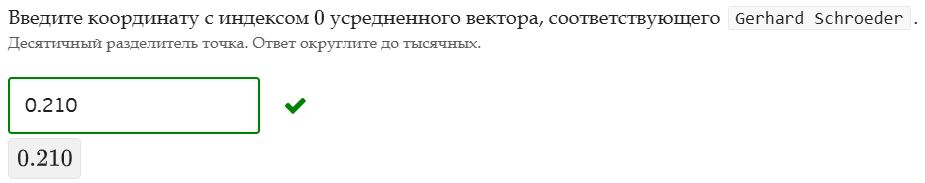

Используя усредненные векторы, постройте изображения всех людей из набора данных:

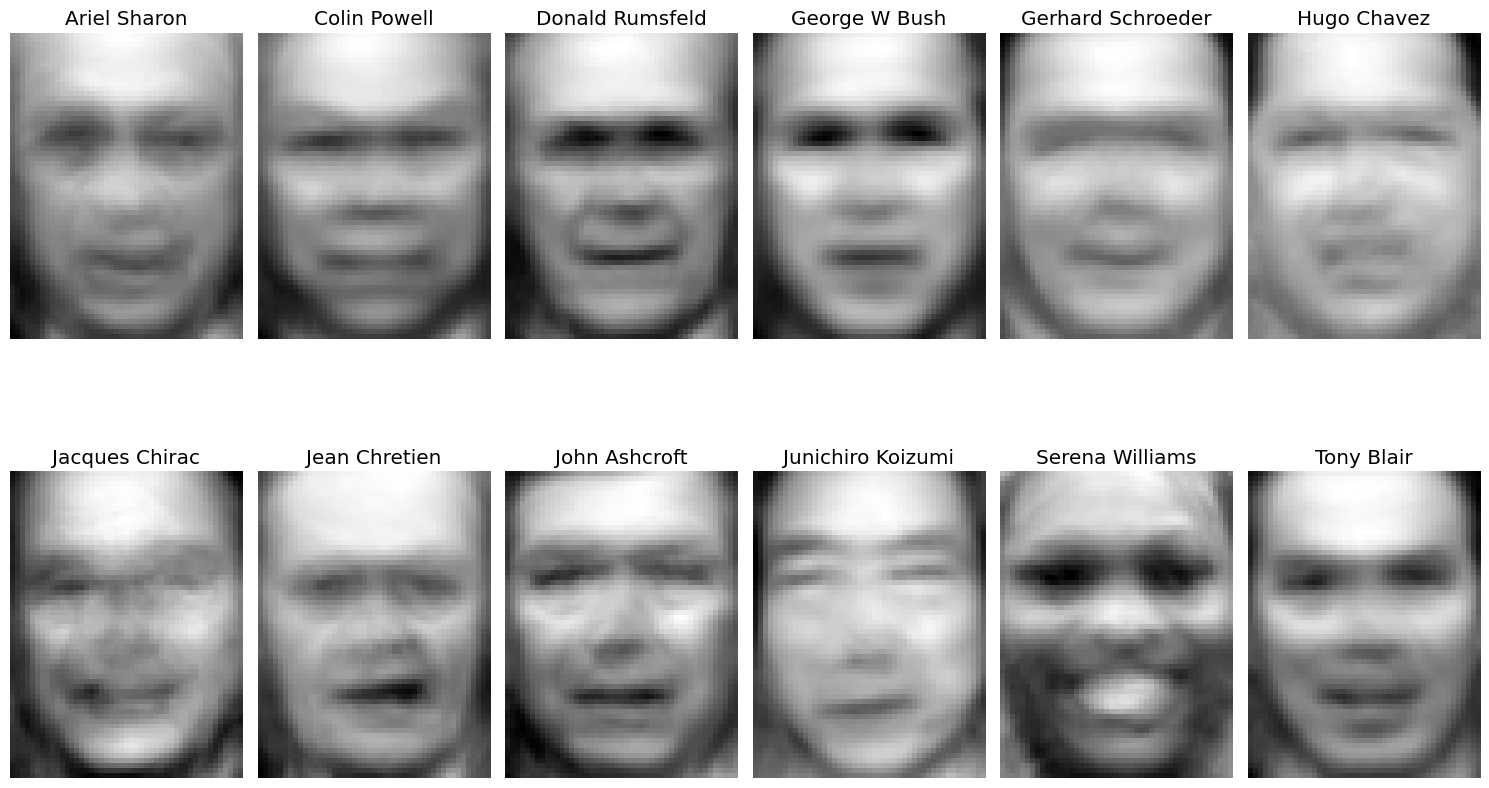

In [61]:
fig, axes = plt.subplots(2, 6, figsize=(15, 10))
axes = axes.flatten()

for i, (person, face_vector) in enumerate(mean_faces.iterrows()):
    img = face_vector.to_numpy().reshape(62, 47)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(person)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

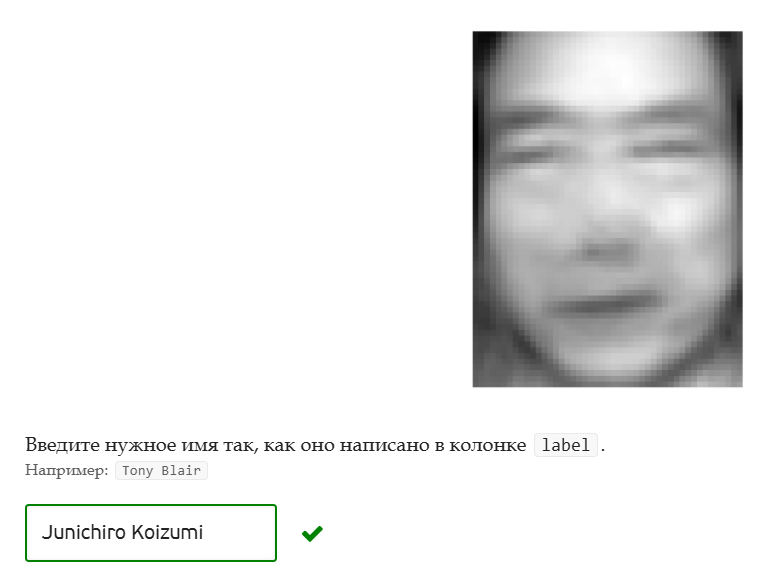

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

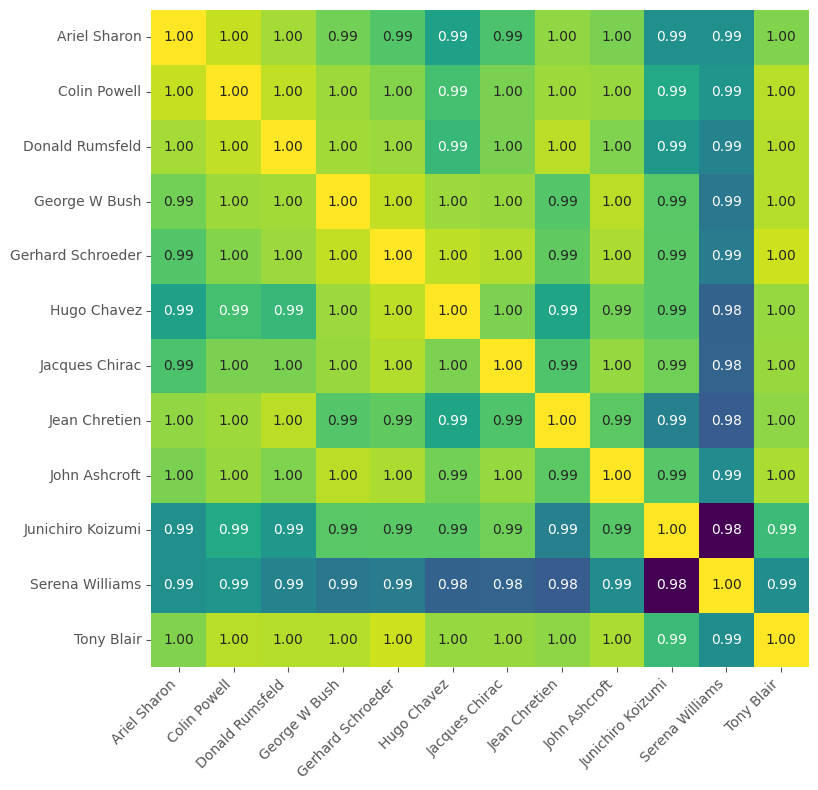

In [62]:
similarity_matrix = cosine_similarity(mean_faces)
sim_df = pd.DataFrame(
    similarity_matrix,
    index=mean_faces.index,
    columns=mean_faces.index
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    sim_df,
    annot=True,
    fmt=".2f",
    cmap='viridis',
    square=True,
    cbar=False
)

plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.yticks(rotation=0)
plt.ylabel('')
plt.tight_layout()
plt.show()

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов:

In [63]:
sim_df.loc['Donald Rumsfeld', 'Serena Williams']

np.float64(0.9866056618941138)

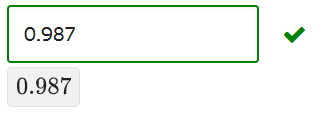

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>:

In [64]:
X = df.drop('label', axis=1)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=5,
    stratify=y
)

## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании:

In [65]:
model = SVC(kernel='linear', random_state=5)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=5)

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>:

In [66]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-score: {f1:.3f}')

F1-score: 0.741


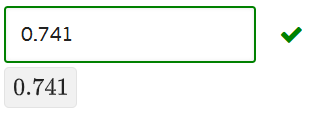

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [67]:
%%time
tuned_parameters = [{
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [1e-3, 1e-4],
    'C': [1, 10, 100, 1000],
    'class_weight': [None, 'balanced'],
    'random_state': [5]
}]

cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.778 total time=   2.6s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   3.3s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.825 total time=   2.4s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.802 total time=   2.8s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.769 total time=   2.0s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.377 total time=   2.8s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.358 total time=   3.2s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.373 total time=   1.5s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [5]}],
             verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [68]:
cv.best_params_

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'sigmoid',
 'random_state': 5}

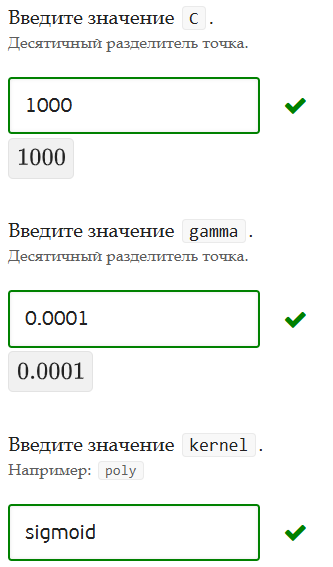

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [69]:
y_pred = cv.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-score: {f1:.3f}')

F1-score: 0.771


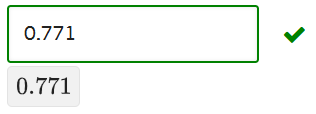

## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [70]:
pca = PCA(svd_solver='full')
pca.fit(X_train)

cumsum = pca.explained_variance_ratio_.cumsum()
n_components = (cumsum > 0.95).argmax() + 1
print(n_components)

173


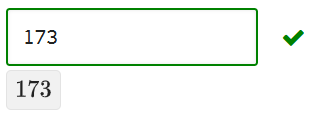

Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [71]:
pca = PCA(n_components=173, svd_solver='full')
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [72]:
%%time
cv_pca = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
cv_pca.fit(X_train_pca, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.750 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.811 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.764 total time=   0.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear, random_state=5;, score=0.745 total time=   0.1s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.344 total time=   0.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.1s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly, random_state=5;, score=0.340 total time=   0.1s
[CV 4/5] END C=1, class_weight=None, gam

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000],
                          'class_weight': [None, 'balanced'],
                          'gamma': [0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'random_state': [5]}],
             verbose=3)

Определите гиперпараметры лучшей полученной модели.

In [73]:
cv_pca.best_params_

{'C': 1000,
 'class_weight': 'balanced',
 'gamma': 0.0001,
 'kernel': 'rbf',
 'random_state': 5}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [74]:
y_pred = cv_pca.predict(X_test_pca)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-score: {f1:.3f}')

F1-score: 0.755


Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.